In [1]:
from typing import Tuple, Dict, List, Callable
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

file_path = '/System/Volumes/Data/Users/rowanamanna/Downloads/Recipe Reviews and User Feedback Dataset.csv'
dataset = pd.read_csv(file_path)
dataset['target'] = (dataset['stars'] >= 3).astype(int)
numeric_features = ['user_reputation', 'reply_count', 'thumbs_up', 'thumbs_down', 'best_score']
X = dataset[numeric_features]
y = dataset['target']

X = X.fillna(X.mean())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)


Training set shape: (14545, 5) (14545,)
Testing set shape: (3637, 5) (3637,)


In [2]:
def add_bias(X: np.ndarray) -> np.ndarray:
    bias = np.ones((X.shape[0], 1))
    return np.hstack((bias, X))


def get_preprocessed_data(data: pd.DataFrame, target_col: str, features: list) -> Tuple[np.ndarray]:
    X = data[features].copy().values
    y = data[target_col].copy().values

    hot_enc = OneHotEncoder(sparse_output=False)
    y_hot = hot_enc.fit_transform(y.reshape(-1, 1))

    X_temp, X_tst, y_temp, y_tst = train_test_split(X, y_hot, test_size=0.2, random_state=42, stratify=y)
    X_trn, X_vld, y_trn, y_vld = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp.argmax(axis=1))

    scaler = StandardScaler()
    X_trn = scaler.fit_transform(X_trn)
    X_vld = scaler.transform(X_vld)
    X_tst = scaler.transform(X_tst)

    X_trn = add_bias(X=X_trn)
    X_vld = add_bias(X=X_vld)
    X_tst = add_bias(X=X_tst)

    if X_vld.shape[1] != X_trn.shape[1]:
        X_vld = X_vld[:, :X_trn.shape[1]]
    if X_tst.shape[1] != X_trn.shape[1]:
        X_tst = X_tst[:, :X_trn.shape[1]]

    return X_trn, y_trn, X_vld, y_vld, X_tst, y_tst


X_train, y_train, X_valid, y_valid, X_test, y_test = get_preprocessed_data(
    data=dataset,
    target_col='target',
    features=['user_reputation', 'reply_count', 'thumbs_up', 'thumbs_down', 'best_score']
)

print(f"Training features shape: {X_train.shape}")
print(f"Validation features shape: {X_valid.shape}")
print(f"Testing features shape: {X_test.shape}")

y_true = np.argmax(y_test, axis=1) if len(y_test.shape) > 1 else y_test

model = LogisticRegression(random_state=42, max_iter=500)
model.fit(X_train, np.argmax(y_train, axis=1))
y_pred = model.predict(X_test)

print("y_true shape:", y_true.shape)
print("y_pred shape:", y_pred.shape)
assert y_true.shape == y_pred.shape, "Shapes of y_true and y_pred must match!"

Training features shape: (10908, 6)
Validation features shape: (3637, 6)
Testing features shape: (3637, 6)
y_true shape: (3637,)
y_pred shape: (3637,)


In [3]:
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix
)

In [4]:
def plot_confusion_matrix(
    y: np.ndarray, 
    y_hat: np.ndarray, 
    class_names: Dict[int, str] = None
) -> pd.DataFrame:

    y = y.flatten()
    y_hat = y_hat.flatten()

    cfm = confusion_matrix(y_true=y, y_pred=y_hat)

    labels = np.sort(np.unique(y))
    if class_names is not None:
        labels = [class_names.get(label, label) for label in labels]

    cfm_df = pd.DataFrame(cfm, index=labels, columns=labels)

    sns.heatmap(cfm_df, annot=True, fmt='g', cmap='Blues')
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

    return cfm_df

In [5]:
def plot_confusion_matrix(
    y: np.ndarray, 
    y_hat: np.ndarray, 
    class_names: Dict[int, str] = None
) -> pd.DataFrame:

    y = y.flatten()
    y_hat = y_hat.flatten()

    cfm = confusion_matrix(y, y_hat)

    labels = np.unique(y)
    if class_names is not None:
        class_labels = [class_names.get(label, str(label)) for label in labels]
    else:
        class_labels = labels

    cfm_df = pd.DataFrame(cfm, index=class_labels, columns=class_labels)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cfm_df, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

    return cfm_df

In [6]:
from sklearn.metrics import classification_report, accuracy_score

accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.2f}")

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Negative", "Positive"]))

Accuracy: 0.88
Classification Report:
              precision    recall  f1-score   support

    Negative       0.61      0.02      0.05       442
    Positive       0.88      1.00      0.94      3195

    accuracy                           0.88      3637
   macro avg       0.75      0.51      0.49      3637
weighted avg       0.85      0.88      0.83      3637



y_true shape: (3637,)
y_pred shape: (3637,)
y_true values: [0 1]
y_pred values: [0 1]


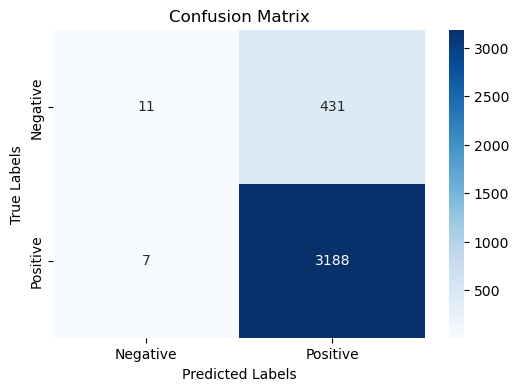

In [7]:
def plot_confusion_matrix(y_true, y_pred, class_names=None):

    cm = confusion_matrix(y_true, y_pred)

    if class_names is None:
        class_names = [str(i) for i in range(len(cm))]

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()
    
y_true = np.argmax(y_test, axis=1) if len(y_test.shape) > 1 else y_test

model = LogisticRegression(random_state=42, max_iter=500)
model.fit(X_train, np.argmax(y_train, axis=1))
y_pred = model.predict(X_test)

print("y_true shape:", y_true.shape)
print("y_pred shape:", y_pred.shape)
print("y_true values:", np.unique(y_true))
print("y_pred values:", np.unique(y_pred))

class_names = ["Negative", "Positive"]

plot_confusion_matrix(y_true, y_pred, class_names=class_names)


In [8]:
def sigmoid(z: np.ndarray) -> np.ndarray:

    return 1 / (1 + np.exp(-z))

In [9]:
def softmax(z: np.ndarray) -> np.ndarray:

    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)


In [10]:
def nll_loss(y: np.ndarray, probs: np.ndarray) -> float:

    nll = -np.sum(y * np.log(probs + 1e-9)) / y.shape[0]  
    return nll


In [11]:
def get_batches(
    data_len: int, 
    batch_size: int = 32,
) -> List[np.ndarray]:

    indices = np.arange(data_len)
    np.random.shuffle(indices)
    batches = [indices[i:i + batch_size] for i in range(0, data_len, batch_size)]

    return batches

In [12]:
class SoftmaxRegression:
    
    def __init__(
        self, 
        alpha: float,
        batch_size: int,
        epochs: int = 1,
        seed: int = 0,
    ):
        self.alpha = alpha
        self.batch_size = batch_size
        self.epochs = epochs
        self.seed = seed
        self.W = None  
        self.trn_loss = [] 
        self.vld_loss = [] 

    def fit(
        self, 
        X: np.ndarray, 
        y: np.ndarray, 
        X_vld: np.ndarray = None, 
        y_vld: np.ndarray = None
    ) -> object:
        np.random.seed(self.seed)
        
        self.W = np.random.rand(X.shape[1], y.shape[1])

        for e in range(self.epochs):  # Loop over epochs
            batches = get_batches(data_len=X.shape[0], batch_size=self.batch_size)
            
            for b in batches: 
                Z = X[b] @ self.W
                y_probs = softmax(Z)  
                self.W -= self.alpha * ((1 / len(b)) * (X[b].T @ (y_probs - y[b])))
            
            self.trn_loss.append(nll_loss(y, softmax(X @ self.W)))
            
            if X_vld is not None and y_vld is not None:
                self.vld_loss.append(nll_loss(y_vld, softmax(X_vld @ self.W)))
        
        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        return np.argmax((X @ self.W), axis=1).reshape(-1, 1)

Training Accuracy: 0.8803


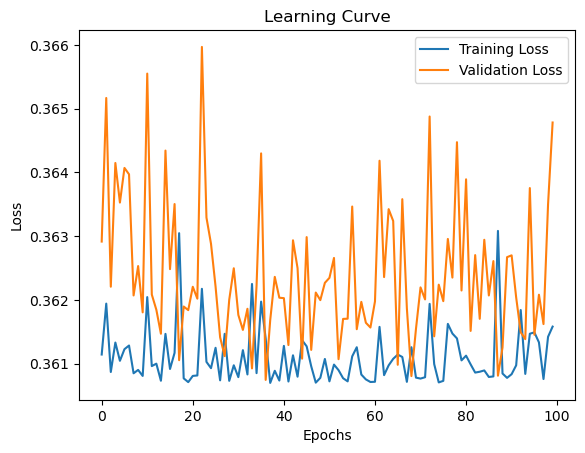

Test Accuracy: 0.8793


In [13]:

X_trn, y_trn, X_vld, y_vld, X_tst, y_tst = get_preprocessed_data(
    data=dataset,
    target_col='target',
    features=['user_reputation', 'reply_count', 'thumbs_up', 'thumbs_down', 'best_score']
)

softmax_model = SoftmaxRegression(alpha=0.1, batch_size=64, epochs=100, seed=42)

softmax_model.fit(X_trn, y_trn, X_vld=X_vld, y_vld=y_vld)

y_trn_pred = softmax_model.predict(X_trn).flatten()
train_accuracy = np.mean(np.argmax(y_trn, axis=1) == y_trn_pred)
print(f"Training Accuracy: {train_accuracy:.4f}")

plt.plot(softmax_model.trn_loss, label='Training Loss')
if softmax_model.vld_loss:
    plt.plot(softmax_model.vld_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

y_tst_pred = softmax_model.predict(X_tst).flatten()
test_accuracy = np.mean(np.argmax(y_tst, axis=1) == y_tst_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")





In [14]:
y_vld_pred = softmax_model.predict(X_vld).flatten()

val_accuracy = np.mean(np.argmax(y_vld, axis=1) == y_vld_pred)
print(f"Validation Accuracy: {val_accuracy:.4f}")

Validation Accuracy: 0.8779


In [15]:
y_tst_pred = softmax_model.predict(X_tst).flatten()

test_accuracy = np.mean(np.argmax(y_tst, axis=1) == y_tst_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.8793


In [16]:
print("Training set shape:", X_trn.shape, y_trn.shape)
print("Validation set shape:", X_vld.shape, y_vld.shape)
print("Test set shape:", X_tst.shape, y_tst.shape)


Training set shape: (10908, 6) (10908, 2)
Validation set shape: (3637, 6) (3637, 2)
Test set shape: (3637, 6) (3637, 2)


In [17]:
'END OF LOGISTIC REGRESSION'

'END OF LOGISTIC REGRESSION'

In [18]:
'START OF KNN'

'START OF KNN'

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

pairplot_df = pd.concat([dataset[numeric_features], dataset['target']], axis=1)

pairplot_df['target'] = pairplot_df['target'].map({0: 'Negative', 1: 'Positive'})

print(pairplot_df.head())

sns.pairplot(pairplot_df, hue='target', diag_kind='kde')
plt.show()


   user_reputation  reply_count  thumbs_up  thumbs_down  best_score    target
0                1            0          0            0         527  Positive
1               50            0          7            0         724  Positive
2               10            0          3            0         710  Positive
3                1            2          2            0         581  Negative
4               10            1          7            0         820  Negative


In [ ]:
def euclidean_distance(x: np.ndarray, Y: np.ndarray) -> np.ndarray:

    assert len(Y.shape) == 2, "Y must be a 2D matrix."
    distances = np.sqrt(np.sum((Y - x) ** 2, axis=1))
    return distances

data_matrix = dataset[numeric_features].to_numpy()

x = data_matrix[0]

distances = euclidean_distance(x, data_matrix)

print("Distances from the first row to all rows in the dataset:")
print(distances)

In [ ]:
def accuracy(y: np.ndarray, y_hat: np.ndarray) -> float:

    y = y.reshape(-1,)  
    y_hat = y_hat.reshape(-1,) 

    are_same = (y == y_hat)
    
    total_correct = np.sum(are_same)
    
    total_samples = len(y)
    
    print(f"Accuracy ratio: {total_correct}/{total_samples}")
    
    accuracy_value = total_correct / total_samples

    return accuracy_value


y_test_flat = np.argmax(y_test, axis=1)  
y_tst_pred_flat = softmax_model.predict(X_tst).flatten() 

test_accuracy = accuracy(y=y_test_flat, y_hat=y_tst_pred_flat)
print(f"Test Accuracy: {test_accuracy:.4f}")


In [ ]:
class KNearestNeighbors:

    def __init__(self, k: int, distance_measure: Callable):

        self.k = k
        self.distance_measure = distance_measure
        self.X: np.ndarray = None
        self.y: np.ndarray = None
        
    def fit(self, X: np.ndarray, y: np.ndarray) -> None:

        self.X = X
        self.y = y

    def predict(self, X: np.ndarray) -> np.ndarray:

        y_hats: list = []
        for x_test in X:
            distances = self.distance_measure(x_test, self.X)
            nearest_indices = np.argsort(distances)[:self.k]
            nearest_labels = self.y[nearest_indices]
            label_counts = np.bincount(nearest_labels)
            y_hats.append(np.argmax(label_counts))
        return np.array(y_hats)

In [ ]:
if len(y_train.shape) > 1:
    y_train_flat = np.argmax(y_train, axis=1)
else:
    y_train_flat = y_train

if len(y_test.shape) > 1:
    y_test_flat = np.argmax(y_test, axis=1)
else:
    y_test_flat = y_test

knn = KNearestNeighbors(k=3, distance_measure=euclidean_distance)

knn.fit(X_train, y_train_flat)

y_pred = knn.predict(X_test)

test_acc = accuracy(y=y_test_flat, y_hat=y_pred)
print(f"Predictions: {y_pred}")
print(f"Test accuracy: {test_acc:.4f}")


In [ ]:
k_values = [1, 25, 50, 100]

for k in k_values:
    print(f"\nRunning KNN with k={k}")
    
    knn = KNearestNeighbors(k=k, distance_measure=euclidean_distance)
    
    y_train_flat = np.argmax(y_train, axis=1) if len(y_train.shape) > 1 else y_train
    y_test_flat = np.argmax(y_test, axis=1) if len(y_test.shape) > 1 else y_test
    
    knn.fit(X_train, y_train_flat)
    
    y_pred = knn.predict(X_test)
    
    print(f"Predictions with k={k}: {y_pred}")
    
    test_acc = accuracy(y=y_test_flat, y_hat=y_pred)
    print(f"Test accuracy with k={k}: {test_acc:.4f}")


In [ ]:
sns.set_palette("coolwarm")
plt.figure(figsize=(8, 6))
sns.countplot(data=dataset, x='stars')
plt.title('Distribution of Recipe Ratings (Stars)')
plt.xlabel('Stars (Rating)')
plt.ylabel('Count')
plt.show()

In [ ]:
numeric_features = ['user_reputation', 'reply_count', 'thumbs_up', 'thumbs_down', 'best_score']
correlation_matrix = dataset[numeric_features].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(data=dataset, x='target', hue='target', palette='Set1', legend=False)
plt.title('Distribution of Recipe Ratings (Positive vs. Negative)')
plt.xlabel('Target (Positive vs. Negative)')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Negative', 'Positive'])
plt.show()